### Задача
В архиве во вложении данные по выдачам кредитов и платежам: плановым и
фактическим. Данные актуальны на 08.12.2022.  
Проанализируйте характер поведения
клиентов с точки зрения просрочки: какая динамика просрочки, наблюдается ли рост или
снижение?
* Несостыковки в данных можно трактовать на свое усмотрение и отразить в
отчете.

### Информация о входных данных


Таблица __payments__ :
* __``order_id``__ — *номер заявки*
* __``paid_at``__ — *дата фактического платежа*
* __``paid_sum``__ — *сумма фактического платежа*



Таблица __orders__ :
* __``order_id``__ — *номер заявки*
* __``created_at``__ — *дата создания заявки*
* __``put_at``__ — *дата выдачи*
* __``closed_at``__ — *дата закрытия*
* __``issued_sum``__ — *сумма выдачи*


Таблица __plan__ :
* __``order_id``__ — *номер заявки*
* __``plan_at``__ — *дата планового платежа*
* __``plan_sum_total``__ — *сумма планового платежа (накопленным итогом)*

### Загрузим данные и подготовим их к анализу

#### Загрузка библиотек

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns; sns.set()
from IPython.display import display
from scipy import stats as st
%matplotlib inline
pd.set_option('display.max_columns', 500)
pd.options.mode.chained_assignment = None

#### Загрузка данных

In [2]:
plan = pd.read_csv('plan.csv')  
orders = pd.read_csv('orders.csv')  
payments = pd.read_csv('payments.csv')

In [3]:
# Функцию для получения основной информации о датафрейме
def datainfo(dataframe):
    display(dataframe.head(10))
    display(dataframe.describe())
    dataframe.info()
    print("", sep = '\n\n')
    print("Name of columns:")
    display(dataframe.columns)
    print("", sep = '\n\n')
    print("Unique values:")
    display(dataframe.nunique())
    print("", sep = '\n\n')
    print("Sum of NaN values:")
    display(dataframe.isna().sum())

### EDA

In [4]:
datainfo(orders)

,order_id,created_at,put_at,closed_at,issued_sum
0,400001732,2022-06-02 00:00:23.997,2022-06-02 20:18:00.180,2022-10-17 11:52:22.190,13600.0
1,400005838,2022-06-02 00:10:22.997,2022-06-02 15:41:33.267,2022-06-02 17:38:43.917,20000.0
2,400007915,2022-06-02 00:18:04.000,2022-06-05 19:17:38.547,2022-06-21 21:55:51.877,5820.0
3,400008952,2022-06-02 00:22:07.000,2022-06-03 14:25:18.033,2022-07-12 10:47:46.307,9000.0
4,400009027,2022-06-02 00:25:39.000,2022-06-02 00:40:40.320,2022-06-22 14:15:07.423,5000.0
5,400010534,2022-06-02 00:46:35.000,2022-06-02 11:42:04.560,2022-07-14 22:15:19.217,14600.0
6,400013633,2022-06-02 00:46:38.000,2022-06-02 00:47:46.277,2022-06-16 03:15:48.960,9500.0
7,400014289,2022-06-02 01:12:32.000,2022-06-02 01:14:07.683,2022-06-06 15:04:37.347,10000.0
8,400014330,2022-06-02 01:13:39.997,2022-06-02 10:56:18.277,2022-06-13 12:16:33.123,5430.0
9,400014464,2022-06-02 01:17:28.000,2022-06-02 01:22:27.323,2022-06-06 16:29:00.720,3000.0


,order_id,issued_sum
count,5.574800e+04,55748.000000
mean,4.477471e+08,7907.202052
std,2.755391e+07,4985.848416
min,4.000017e+08,1000.000000
25%,4.237195e+08,4000.000000
50%,4.480092e+08,7290.000000
75%,4.716685e+08,10850.000000
max,4.951775e+08,28570.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55748 entries, 0 to 55747
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   order_id    55748 non-null  int64  
 1   created_at  55748 non-null  object 
 2   put_at      55748 non-null  object 
 3   closed_at   46472 non-null  object 
 4   issued_sum  55748 non-null  float64
dtypes: float64(1), int64(1), object(3)
memory usage: 2.1+ MB

Name of columns:


Index(['order_id', 'created_at', 'put_at', 'closed_at', 'issued_sum'], dtype='object')


Unique values:


order_id      55748
created_at    55039
put_at        55732
closed_at     46453
issued_sum       70
dtype: int64


Sum of NaN values:


order_id         0
created_at       0
put_at           0
closed_at     9276
issued_sum       0
dtype: int64

In [10]:
print('Самая последняя дата выдачи кредита в наших данных: ',orders['created_at'].max())
print('Самая последняя дата платежа за кредит в наших данных: ',payments['paid_at'].max())
print('Средняя дата выдачи кредита, в котором отсутствует дата погашения: ',orders[orders['closed_at'].isna()]['created_at'].mean())
print('Средняя дата выдачи кредита, в котором отсутствует дата погашения: ',orders[orders['closed_at'].isna()]['created_at'].max())
print('Процент пропущенных значений в closed_at: {:.2%}'.format(orders['closed_at'].isna().sum()/len(orders['closed_at'])))

Самая последняя дата выдачи кредита в наших данных:  2022-08-31 23:49:42.997000
Самая последняя дата платежа за кредит в наших данных:  2022-12-08 13:28:23.703000
Средняя дата выдачи кредита, в котором отсутствует дата погашения:  2022-07-22 18:19:15.041310720
Средняя дата выдачи кредита, в котором отсутствует дата погашения:  2022-08-31 23:49:42.997000
Процент пропущенных значений в closed_at: 16.64%


Видим 9276 пропущенных значений в поле closed_at, что связано с тем, что кредит просто не был погашен на момент последнего наблюдения.
Получается, что пропуски у нас неслучайные, просто удаление не будет хорошим решением.
В таком случае можно как вариант присвоить какое-то число, чтоб точно понимать, что данный кредит ещё не закрыт, либо заменить на часто встречающуюся дату.  
Но пока есть предположение, что пропуски не повлияют на анализ, т.к. closed_at я не планирую рассматривать

In [6]:
datainfo(payments)

,order_id,paid_at,paid_sum
0,400013633,2022-06-02 00:48:13.800,2500.0
1,400018480,2022-06-02 01:52:05.707,1070.0
2,400032001,2022-06-02 04:55:40.307,4200.0
3,400033195,2022-06-02 05:44:23.480,2850.0
4,400039407,2022-06-02 06:53:54.503,10100.0
5,400116494,2022-06-02 08:09:42.393,4200.0
6,400138751,2022-06-02 09:39:18.877,11110.0
7,400224041,2022-06-02 10:33:26.510,3570.0
8,400020168,2022-06-02 10:39:36.157,4200.0
9,400024960,2022-06-02 10:40:25.193,2500.0


,order_id,paid_sum
count,1.432840e+05,143284.000000
mean,4.471506e+08,3902.743457
std,2.742581e+07,4528.141434
min,4.000017e+08,0.020000
25%,4.231827e+08,1039.700000
50%,4.470855e+08,2125.600000
75%,4.707384e+08,4600.000000
max,4.951775e+08,49469.370000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 143284 entries, 0 to 143283
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   order_id  143284 non-null  int64  
 1   paid_at   143284 non-null  object 
 2   paid_sum  143284 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 3.3+ MB

Name of columns:


Index(['order_id', 'paid_at', 'paid_sum'], dtype='object')


Unique values:


order_id     53730
paid_at     143172
paid_sum     16086
dtype: int64


Sum of NaN values:


order_id    0
paid_at     0
paid_sum    0
dtype: int64

In [7]:
datainfo(plan)

,order_id,plan_at,plan_sum_total
0,400001732,2022-06-02,5600.0
1,400001732,2022-07-02,9450.0
2,400001732,2022-08-01,12170.0
3,400001732,2022-08-31,14890.0
4,400001732,2022-09-30,17610.0
5,400001732,2022-10-30,20330.0
6,400001732,2022-11-29,23050.0
7,400005838,2022-06-17,23000.0
8,400007915,2022-06-05,1820.0
9,400007915,2022-06-20,2730.0


,order_id,plan_sum_total
count,4.202820e+05,4.202820e+05
mean,4.478982e+08,8.662569e+03
std,2.756899e+07,1.095191e+04
min,4.000017e+08,0.000000e+00
25%,4.237028e+08,3.570000e+03
50%,4.480977e+08,6.900000e+03
75%,4.720303e+08,1.215847e+04
max,4.951775e+08,2.300000e+06


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 420282 entries, 0 to 420281
Data columns (total 3 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   order_id        420282 non-null  int64  
 1   plan_at         420282 non-null  object 
 2   plan_sum_total  420282 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 9.6+ MB

Name of columns:


Index(['order_id', 'plan_at', 'plan_sum_total'], dtype='object')


Unique values:


order_id          55748
plan_at             307
plan_sum_total    97716
dtype: int64


Sum of NaN values:


order_id          0
plan_at           0
plan_sum_total    0
dtype: int64

Во всех таблицах есть столбцы с некорректным типом данных (object вместо datetime64)

In [8]:
# Функцию для изменения типа данных на 'datetime64'
def convert_to_time(dataframe, column, formtype):
    if formtype == 1:    # Если формат даты (год-месяц-день час:минута:секунда)
        result = pd.to_datetime(dataframe[column], format='%Y-%m-%d %H:%M:%S.%f')
        return result
    elif formtype == 2:  # Если формат даты (год-месяц-день)
        result = pd.to_datetime(dataframe[column], format='%Y-%m-%d')
        return result
    else:
        print('Некорректный формат даты')

In [9]:
#Изменяем типы данных и проверяем
payments['paid_at'] = convert_to_time(payments, 'paid_at', 1) 
plan['plan_at'] = convert_to_time(plan, 'plan_at', 2)
orders['created_at'] = convert_to_time(orders, 'created_at', 1)
orders['put_at'] = convert_to_time(orders, 'put_at', 1)
orders['closed_at'] = convert_to_time(orders, 'closed_at', 1)
print(payments['paid_at'].dtype)  
print(plan['plan_at'].dtype) 
print(orders['created_at'].dtype)
print(orders['put_at'].dtype)
print(orders['closed_at'].dtype)

datetime64[ns]
datetime64[ns]
datetime64[ns]
datetime64[ns]
datetime64[ns]


### Analysis

Начнем с того, что посмотрим на разницу количества платежей запланированных и фактических

,plan_payment_count,fact_payment_count
order_id,,
468503876,13,1
408114843,1,1
424485839,13,3
484166169,7,4
470847137,13,4
456362592,7,2
475234196,13,8
442898440,1,1
413050897,13,3


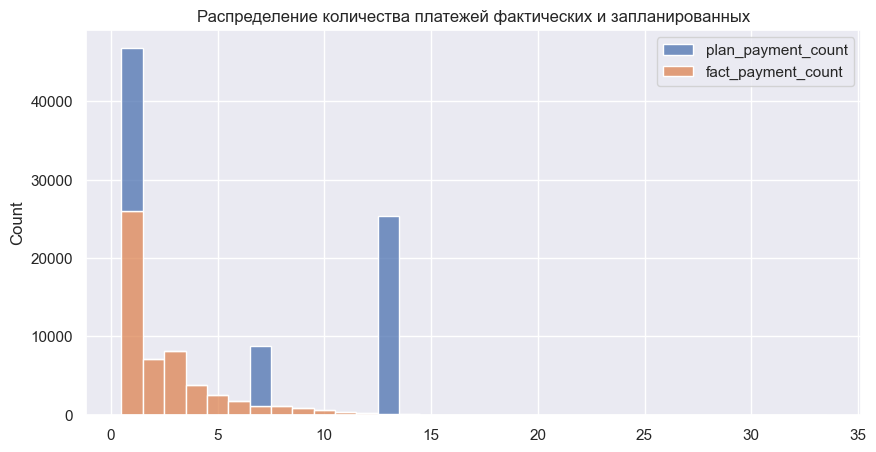

,plan_payment_count,fact_payment_count
count,53730.000000,53730.000000
mean,7.498790,2.666741
std,5.537334,2.407184
min,1.000000,1.000000
25%,1.000000,1.000000
50%,7.000000,2.000000
75%,13.000000,3.000000
max,25.000000,33.000000


In [11]:
# Количество платежей plan и payments для каждого order_id
plan_count = plan.groupby(['order_id']).agg(plan_payment_count = ('plan_at','count'))
fact_count = payments.groupby(['order_id']).agg(fact_payment_count = ('paid_at','count'))
data1 = plan_count.merge(fact_count, on='order_id')
display(data1.sample(10))

plt.figure(figsize=(10,5))
sns.histplot(data1, bins=10,kde=False, stat="count", binwidth=3, multiple="stack", discrete = True)
plt.title('Распределение количества платежей фактических и запланированных')
plt.show() 


display(data1.describe())

***Небольшие инсайты в данных:***
* В среднем клиенты закрывают кредиты практически в 3 раза бысрее, чем было запланировано, т.е. в среднем за 3 платежа.
* В данных явно присутствуют просрочки погашения кредита. Это явно можно увидеть по первому столбцу нашего графика, планово было запланировано погашение кредита за 1 платеж, а фактически количество таких платежей намного ниже.

#### Теперь поработаем с просрочкой.
Нам надо рассчитать разницу в датах планновых и фактических платежей, для этого нужно объединить таблицы payments и plan, и таким образом чтоб платежи были последовательны.
Поэтому добавим в таблицы индекс платежа для каждого order_id  
А также преобразуем plan_sum_total из накопленной суммы в обычную, чтоб потом мочь увидеть разницу в сумме плановых и фактических платежей

In [237]:
payments = payments.sort_values(by = ['order_id','paid_at'])
payments['payment_index'] = payments.groupby('order_id').cumcount() + 1
plan = plan.sort_values(by = ['order_id','plan_at'])
plan['payment_index'] = plan.groupby('order_id').cumcount() + 1
display(plan.head(20))

,order_id,plan_at,plan_sum_total,payment_index
0,400001732,2022-06-02,5600.00,1
1,400001732,2022-07-02,9450.00,2
2,400001732,2022-08-01,12170.00,3
3,400001732,2022-08-31,14890.00,4
4,400001732,2022-09-30,17610.00,5
5,400001732,2022-10-30,20330.00,6
6,400001732,2022-11-29,23050.00,7
7,400005838,2022-06-17,23000.00,1
8,400007915,2022-06-05,1820.00,1
9,400007915,2022-06-20,2730.00,2


In [313]:
delays = pd.merge(payments, plan, on=['order_id','payment_index'], how = 'left')
#преобразуем накопленную сумму планновых платежей
delays['plan_sum'] = delays.groupby('order_id')['plan_sum_total'].diff().fillna(delays['plan_sum_total'])

In [231]:
datainfo(delays)

,order_id,paid_at,paid_sum,payment_index,plan_at,plan_sum_total,plan_sum
0,400001732,2022-06-02 20:20:16.790,5600.0,1,2022-06-02,5600.0,5600.0
1,400001732,2022-06-16 16:05:26.007,3850.0,2,2022-07-02,9450.0,3850.0
2,400001732,2022-07-15 12:32:34.087,2720.0,3,2022-08-01,12170.0,2720.0
3,400001732,2022-08-16 12:38:01.237,2720.0,4,2022-08-31,14890.0,2720.0
4,400001732,2022-09-15 12:14:48.867,2720.0,5,2022-09-30,17610.0,2720.0
5,400001732,2022-09-27 16:04:50.630,2720.0,6,2022-10-30,20330.0,2720.0
6,400001732,2022-10-17 11:52:22.190,2720.0,7,2022-11-29,23050.0,2720.0
7,400005838,2022-06-02 17:38:43.917,20200.0,1,2022-06-17,23000.0,23000.0
8,400007915,2022-06-05 19:18:12.457,1820.0,1,2022-06-05,1820.0,1820.0
9,400007915,2022-06-21 21:55:51.877,6759.1,2,2022-06-20,2730.0,910.0


,order_id,paid_at,paid_sum,payment_index,plan_at,plan_sum_total,plan_sum
count,1.432840e+05,143284,143284.000000,143284.000000,142053,1.420530e+05,1.420530e+05
mean,4.471506e+08,2022-08-21 00:37:39.483453696,3902.743457,2.919796,2022-08-19 21:24:55.393972736,6.558506e+03,2.885550e+03
min,4.000017e+08,2022-06-02 00:48:13.800000,0.020000,1.000000,2022-06-02 00:00:00,0.000000e+00,0.000000e+00
25%,4.231827e+08,2022-07-19 15:47:43.870749952,1039.700000,1.000000,2022-07-19 00:00:00,2.393420e+03,9.100000e+02
50%,4.470855e+08,2022-08-16 23:32:21.457999872,2125.600000,2.000000,2022-08-16 00:00:00,4.804690e+03,1.592380e+03
75%,4.707384e+08,2022-09-15 17:47:56.326749952,4600.000000,4.000000,2022-09-14 00:00:00,9.200000e+03,2.850000e+03
max,4.951775e+08,2022-12-08 13:28:23.703000,49469.370000,33.000000,2023-03-06 00:00:00,2.300000e+06,2.300000e+06
std,2.742581e+07,NaN,4528.141434,2.370589,NaN,1.609055e+04,1.564693e+04


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 143284 entries, 0 to 143283
Data columns (total 7 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   order_id        143284 non-null  int64         
 1   paid_at         143284 non-null  datetime64[ns]
 2   paid_sum        143284 non-null  float64       
 3   payment_index   143284 non-null  int64         
 4   plan_at         142053 non-null  datetime64[ns]
 5   plan_sum_total  142053 non-null  float64       
 6   plan_sum        142053 non-null  float64       
dtypes: datetime64[ns](2), float64(3), int64(2)
memory usage: 7.7 MB

Name of columns:


Index(['order_id', 'paid_at', 'paid_sum', 'payment_index', 'plan_at',
       'plan_sum_total', 'plan_sum'],
      dtype='object')


Unique values:


order_id           53730
paid_at           143172
paid_sum           16086
payment_index         33
plan_at              262
plan_sum_total     20470
plan_sum           10994
dtype: int64


Sum of NaN values:


order_id             0
paid_at              0
paid_sum             0
payment_index        0
plan_at           1231
plan_sum_total    1231
plan_sum          1231
dtype: int64

* Видим что появились пропущенные значения в plan_at, plan_sum_total, plan_sum

In [232]:
display(plan.query('order_id == 400158902'))
display(payments.query('order_id == 400158902'))

,order_id,plan_at,plan_sum_total,payment_index
686,400158902,2022-07-12,10465.76,1


,order_id,paid_at,paid_sum,payment_index
44545,400158902,2022-07-27 09:49:20.320,965.76,1
44546,400158902,2022-07-27 09:49:22.697,4750.00,2
44547,400158902,2022-07-27 09:49:25.430,4750.00,3


In [233]:
print(delays[delays['plan_at'].isna()])

         order_id                 paid_at  paid_sum  payment_index plan_at  \
256     400158902 2022-07-27 09:49:22.697   4750.00              2     NaT   
257     400158902 2022-07-27 09:49:25.430   4750.00              3     NaT   
473     400282460 2022-06-24 08:14:23.637   2750.00              2     NaT   
474     400282460 2022-06-24 08:14:23.730   2750.00              3     NaT   
725     400444341 2022-11-29 12:52:18.523   1030.00              8     NaT   
...           ...                     ...       ...            ...     ...   
142956  494937951 2022-12-06 19:47:04.797   1413.53             15     NaT   
143044  495019341 2022-10-09 08:35:45.197   1500.00              2     NaT   
143045  495019341 2022-10-09 08:35:47.230   1500.00              3     NaT   
143194  495112756 2022-09-20 08:12:06.810   2000.00              2     NaT   
143195  495112756 2022-09-20 08:12:09.017   2000.00              3     NaT   

        plan_sum_total  plan_sum  
256                NaN      

Пропущенные значения появились в ситуациях, где запланированных платежей меньше, чем фактических.  
Для таких платежей(сумм) пропущенные значения нужно заменить на дату(суммы) последнего планового платежа

In [239]:
delays.sort_values(by=['order_id','payment_index'], inplace = True)
delays['plan_at'] = delays['plan_at'].ffill()
delays['plan_sum_total'] = delays['plan_sum_total'].ffill()
delays['plan_sum'] = delays['plan_sum'].ffill()

In [240]:
datainfo(delays)

,order_id,paid_at,paid_sum,payment_index,plan_at,plan_sum_total,plan_sum
0,400001732,2022-06-02 20:20:16.790,5600.0,1,2022-06-02,5600.0,5600.0
1,400001732,2022-06-16 16:05:26.007,3850.0,2,2022-07-02,9450.0,3850.0
2,400001732,2022-07-15 12:32:34.087,2720.0,3,2022-08-01,12170.0,2720.0
3,400001732,2022-08-16 12:38:01.237,2720.0,4,2022-08-31,14890.0,2720.0
4,400001732,2022-09-15 12:14:48.867,2720.0,5,2022-09-30,17610.0,2720.0
5,400001732,2022-09-27 16:04:50.630,2720.0,6,2022-10-30,20330.0,2720.0
6,400001732,2022-10-17 11:52:22.190,2720.0,7,2022-11-29,23050.0,2720.0
7,400005838,2022-06-02 17:38:43.917,20200.0,1,2022-06-17,23000.0,23000.0
8,400007915,2022-06-05 19:18:12.457,1820.0,1,2022-06-05,1820.0,1820.0
9,400007915,2022-06-21 21:55:51.877,6759.1,2,2022-06-20,2730.0,910.0


,order_id,paid_at,paid_sum,payment_index,plan_at,plan_sum_total,plan_sum
count,1.432840e+05,143284,143284.000000,143284.000000,143284,1.432840e+05,1.432840e+05
mean,4.471506e+08,2022-08-21 00:37:39.483453696,3902.743457,2.919796,2022-08-20 00:04:22.304235008,6.602285e+03,2.922266e+03
min,4.000017e+08,2022-06-02 00:48:13.800000,0.020000,1.000000,2022-06-02 00:00:00,0.000000e+00,0.000000e+00
25%,4.231827e+08,2022-07-19 15:47:43.870749952,1039.700000,1.000000,2022-07-19 00:00:00,2.402340e+03,9.100000e+02
50%,4.470855e+08,2022-08-16 23:32:21.457999872,2125.600000,2.000000,2022-08-16 00:00:00,4.810450e+03,1.594690e+03
75%,4.707384e+08,2022-09-15 17:47:56.326749952,4600.000000,4.000000,2022-09-14 00:00:00,9.200000e+03,2.850000e+03
max,4.951775e+08,2022-12-08 13:28:23.703000,49469.370000,33.000000,2023-03-06 00:00:00,2.300000e+06,2.300000e+06
std,2.742581e+07,NaN,4528.141434,2.370589,NaN,1.604756e+04,1.559304e+04


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 143284 entries, 0 to 143283
Data columns (total 7 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   order_id        143284 non-null  int64         
 1   paid_at         143284 non-null  datetime64[ns]
 2   paid_sum        143284 non-null  float64       
 3   payment_index   143284 non-null  int64         
 4   plan_at         143284 non-null  datetime64[ns]
 5   plan_sum_total  143284 non-null  float64       
 6   plan_sum        143284 non-null  float64       
dtypes: datetime64[ns](2), float64(3), int64(2)
memory usage: 7.7 MB

Name of columns:


Index(['order_id', 'paid_at', 'paid_sum', 'payment_index', 'plan_at',
       'plan_sum_total', 'plan_sum'],
      dtype='object')


Unique values:


order_id           53730
paid_at           143172
paid_sum           16086
payment_index         33
plan_at              262
plan_sum_total     20470
plan_sum           10994
dtype: int64


Sum of NaN values:


order_id          0
paid_at           0
paid_sum          0
payment_index     0
plan_at           0
plan_sum_total    0
plan_sum          0
dtype: int64

In [241]:
# Добавим в таблицу разнизу между plan_at и paid_at, а также разницу в платежах
'''
days - количество дней между plan_at и paid_at
overdue - bool переменная (1 - просроченный платеж, 0 - нормальный)
debt - разница планнового платежа и фактического
debt_bool - bool переменная (1 - факт.платеж < планового , 0 - факт.платеж >= планового)
'''
#Немного преобразовала даты, чтоб не получались просрочки там где их их не должно быть
delays['paid_at'] = delays['paid_at'].dt.date
delays['plan_at'] = delays['plan_at'].dt.date
delays['days'] = ((delays['plan_at']- delays['paid_at']).apply(lambda x: x.days))
delays['overdue'] = (delays['days']<0).astype(int)
###
delays['debt'] = delays['plan_sum'] - delays['paid_sum']
delays['debt_bool'] = (delays['debt']<0).astype(int)

#выведем результат для конкретного примера
datainfo(delays.query('order_id == 400001732'))

,order_id,paid_at,paid_sum,payment_index,plan_at,plan_sum_total,plan_sum,days,overdue,debt,debt_bool
0,400001732,2022-06-02,5600.0,1,2022-06-02,5600.0,5600.0,0,0,0.0,0
1,400001732,2022-06-16,3850.0,2,2022-07-02,9450.0,3850.0,16,0,0.0,0
2,400001732,2022-07-15,2720.0,3,2022-08-01,12170.0,2720.0,17,0,0.0,0
3,400001732,2022-08-16,2720.0,4,2022-08-31,14890.0,2720.0,15,0,0.0,0
4,400001732,2022-09-15,2720.0,5,2022-09-30,17610.0,2720.0,15,0,0.0,0
5,400001732,2022-09-27,2720.0,6,2022-10-30,20330.0,2720.0,33,0,0.0,0
6,400001732,2022-10-17,2720.0,7,2022-11-29,23050.0,2720.0,43,0,0.0,0


,order_id,paid_sum,payment_index,plan_sum_total,plan_sum,days,overdue,debt,debt_bool
count,7.0,7.000000,7.000000,7.000000,7.000000,7.000000,7.0,7.0,7.0
mean,400001732.0,3292.857143,4.000000,14728.571429,3292.857143,19.857143,0.0,0.0,0.0
std,0.0,1101.070907,2.160247,6146.696751,1101.070907,13.981280,0.0,0.0,0.0
min,400001732.0,2720.000000,1.000000,5600.000000,2720.000000,0.000000,0.0,0.0,0.0
25%,400001732.0,2720.000000,2.500000,10810.000000,2720.000000,15.000000,0.0,0.0,0.0
50%,400001732.0,2720.000000,4.000000,14890.000000,2720.000000,16.000000,0.0,0.0,0.0
75%,400001732.0,3285.000000,5.500000,18970.000000,3285.000000,25.000000,0.0,0.0,0.0
max,400001732.0,5600.000000,7.000000,23050.000000,5600.000000,43.000000,0.0,0.0,0.0


<class 'pandas.core.frame.DataFrame'>
Index: 7 entries, 0 to 6
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   order_id        7 non-null      int64  
 1   paid_at         7 non-null      object 
 2   paid_sum        7 non-null      float64
 3   payment_index   7 non-null      int64  
 4   plan_at         7 non-null      object 
 5   plan_sum_total  7 non-null      float64
 6   plan_sum        7 non-null      float64
 7   days            7 non-null      int64  
 8   overdue         7 non-null      int32  
 9   debt            7 non-null      float64
 10  debt_bool       7 non-null      int32  
dtypes: float64(4), int32(2), int64(3), object(2)
memory usage: 616.0+ bytes

Name of columns:


Index(['order_id', 'paid_at', 'paid_sum', 'payment_index', 'plan_at',
       'plan_sum_total', 'plan_sum', 'days', 'overdue', 'debt', 'debt_bool'],
      dtype='object')


Unique values:


order_id          1
paid_at           7
paid_sum          3
payment_index     7
plan_at           7
plan_sum_total    7
plan_sum          3
days              6
overdue           1
debt              1
debt_bool         1
dtype: int64


Sum of NaN values:


order_id          0
paid_at           0
paid_sum          0
payment_index     0
plan_at           0
plan_sum_total    0
plan_sum          0
days              0
overdue           0
debt              0
debt_bool         0
dtype: int64

In [307]:
res = pd.DataFrame()
res = delays.groupby('overdue').agg(overdue_count = ('overdue','count'))
res

,overdue_count
overdue,
0,107090
1,36194


In [308]:
#print('Процент просроченных платежей: {:.2%}'.format(res.query('overdue == 0')['overdue_count']/sum(res['overdue_count'])))
print(f"{ res.query('overdue == 1')['overdue_count']/sum(res['overdue_count']) }")

overdue
1    0.252603
Name: overdue_count, dtype: float64


<Figure size 500x500 with 0 Axes>

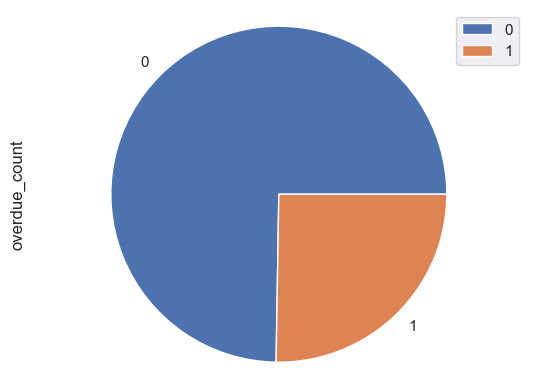

In [312]:
plt.figure(figsize=(5,5))
res.plot.pie(y ='overdue_count')
plt.axis('equal')
plt.show()

#### Процент просроченных платежей - 25,2%

#### Посмотрим сначала на те данные, где точно присутствует просрочка платежей

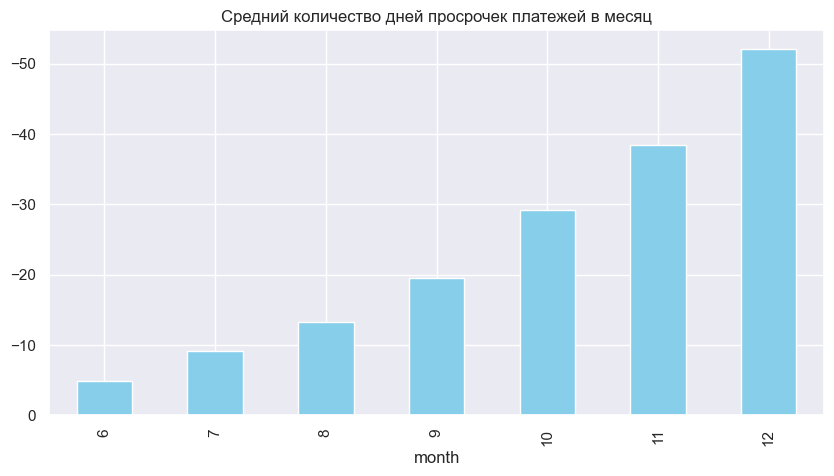

In [269]:
delays['month'] = delays['paid_at'].apply(lambda x: x.month)
filtered_delays = delays[delays['overdue'] == 1]
overdue_trend = filtered_delays.groupby('month')['days'].mean()
plt.figure(figsize=(10,5))
overdue_trend.plot(kind = 'bar', color = 'skyblue')
plt.gca().invert_yaxis()
plt.title('Средний количество дней просрочек платежей в месяц')
plt.show()

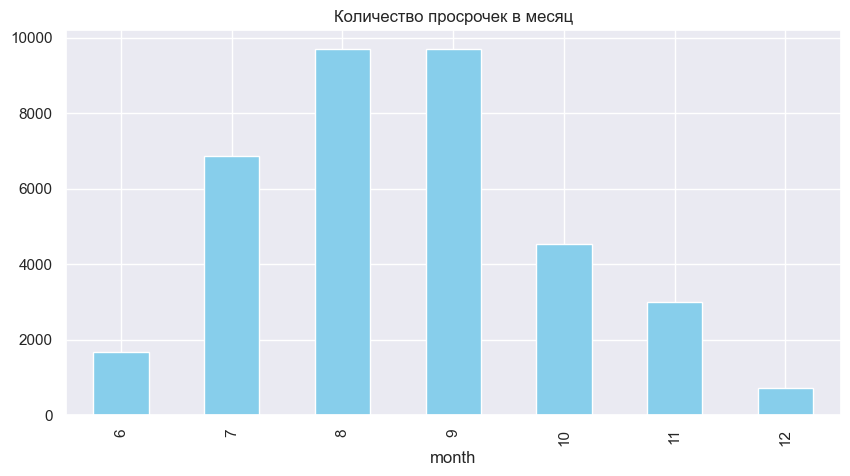

In [267]:
filtered_delays = delays[delays['overdue'] == 1]
overdue_trend = filtered_delays.groupby('month')['overdue'].count()
plt.figure(figsize=(10,5))
overdue_trend.plot(kind = 'bar', color = 'skyblue')
plt.title('Количество просрочек в месяц')
plt.show()

* По длительности просрочки тренд позрастающий, к декабрю средняя задержка платежа достигает 50 дней
* Наибольшее количество задержанных платежей было в августе и сентябре

#### Посмотрим на платежи, которые не задерживались

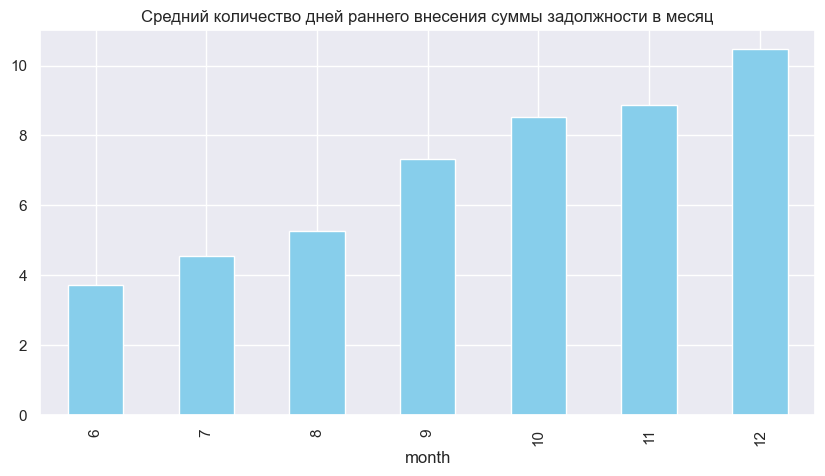

In [278]:
delays['month'] = delays['paid_at'].apply(lambda x: x.month)
filtered_delays = delays[delays['overdue'] == 0]
overdue_trend = filtered_delays.groupby('month')['days'].mean()
plt.figure(figsize=(10,5))
overdue_trend.plot(kind = 'bar', color = 'skyblue')
plt.title('Средний количество дней раннего внесения суммы задолжности в месяц')
plt.show()

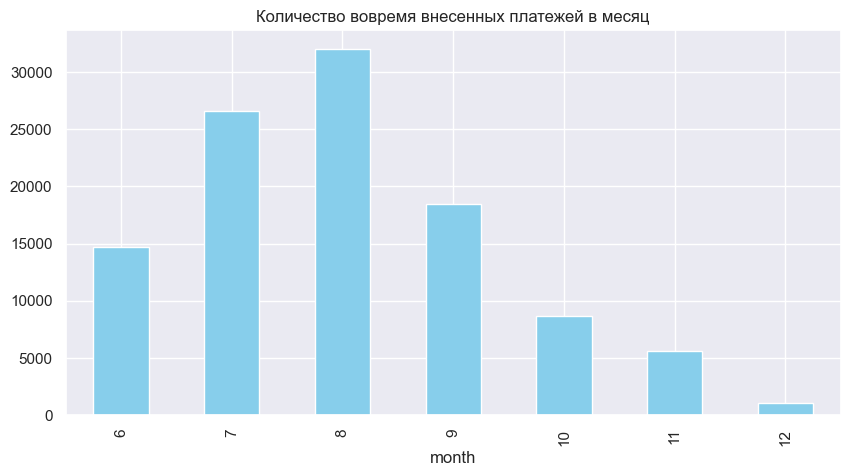

In [273]:
filtered_delays = delays[delays['overdue'] == 0]
overdue_trend = filtered_delays.groupby('month')['overdue'].count()
plt.figure(figsize=(10,5))
overdue_trend.plot(kind = 'bar', color = 'skyblue')
plt.title('Количество вовремя внесенных платежей в месяц')
plt.show()

* Пик по количеству вовремя внесенных платежей по кредиту был в августе и стремительно падал с тех пор
* Динамика количества дней раннего внесения суммы задолжности положительная и в декабре достигает в среднем 10 дней

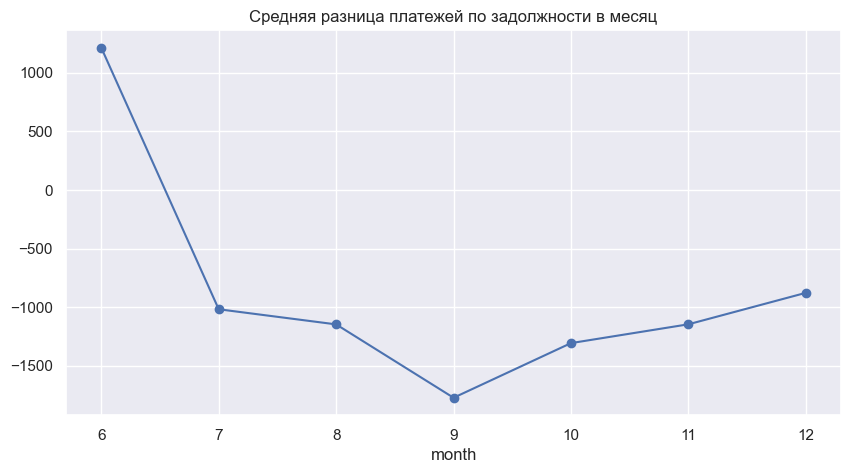

In [284]:
#filtered_delays = delays[delays['overdue'] == 0]
debt_trend = delays.groupby('month')['debt'].mean()
plt.figure(figsize=(10,5))
debt_trend.plot(kind = 'line',marker = 'o')
plt.title('Средняя разница платежей по задолжности в месяц')
plt.show()

* В среднем получается только в июне вносили суммы большие, чем плановый платеж
* Если разбить график на платежи с задолжностями и нет, то можно увидеть что с сентября платежи чуть увеличивались, но всё ещё не перекрывали плановые, в среднем наименьшая разница была в декабре и составляла -1600

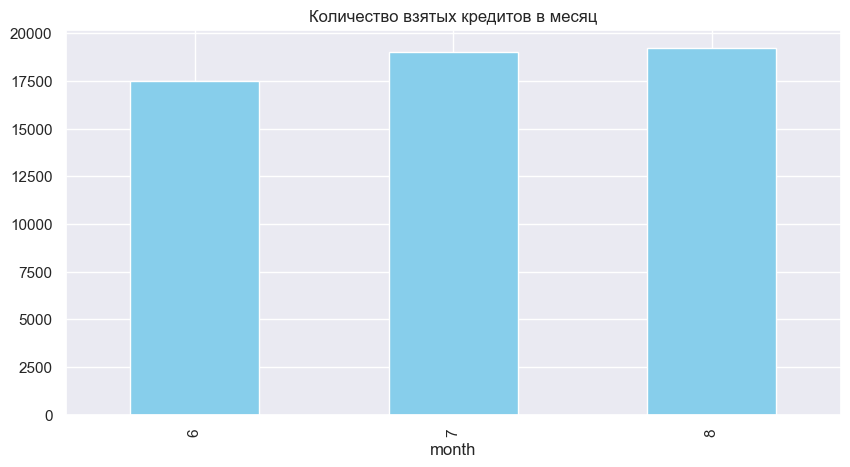

In [283]:
orders['month'] = orders['created_at'].dt.month
count_debts = orders.groupby('month')['created_at'].count()
plt.figure(figsize=(10,5))
count_debts.plot(kind = 'bar', color = 'skyblue')
plt.title('Количество взятых кредитов в месяц')
plt.show()

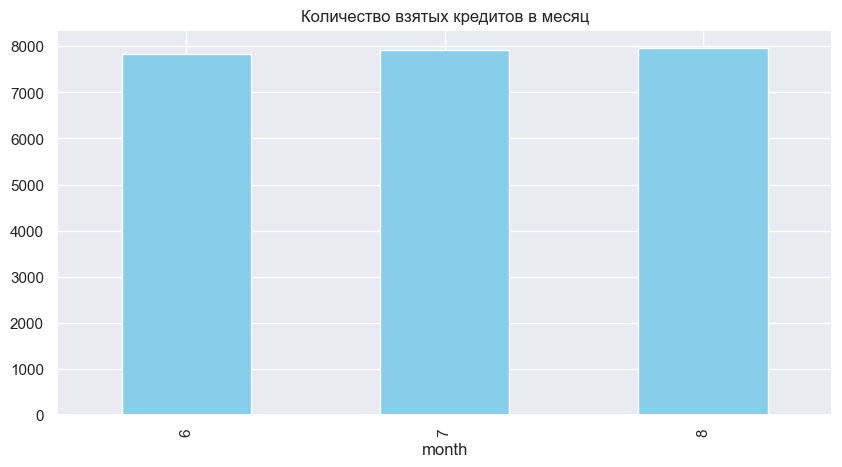

In [299]:
count_debts = orders.groupby('month')['issued_sum'].mean()
plt.figure(figsize=(10,5))
count_debts.plot(kind = 'bar', color = 'skyblue')
plt.title('Количество взятых кредитов в месяц')
plt.show()

* По сумме и по количеству взятых кредитов месяца не отличаются практически

Может быть есть какая-то зависимость от наличия задолжностей?  
Объединим orders и delays и построим графики с просрочкой и без

In [300]:
orders = pd.merge(delays, orders, on=['order_id'], how = 'outer')
display(orders)

,order_id,paid_at,paid_sum,payment_index,plan_at,plan_sum_total,plan_sum,days,overdue,debt,debt_bool,year,month_x,created_at,put_at,closed_at,issued_sum,month_y
0,400001732,2022-06-02,5600.00,1.0,2022-06-02,5600.00,5600.00,0.0,0.0,0.000000e+00,0.0,2022-06-01,6.0,2022-06-02 00:00:23.997,2022-06-02 20:18:00.180,2022-10-17 11:52:22.190,13600.0,6
1,400001732,2022-06-16,3850.00,2.0,2022-07-02,9450.00,3850.00,16.0,0.0,0.000000e+00,0.0,2022-06-01,6.0,2022-06-02 00:00:23.997,2022-06-02 20:18:00.180,2022-10-17 11:52:22.190,13600.0,6
2,400001732,2022-07-15,2720.00,3.0,2022-08-01,12170.00,2720.00,17.0,0.0,0.000000e+00,0.0,2022-07-01,7.0,2022-06-02 00:00:23.997,2022-06-02 20:18:00.180,2022-10-17 11:52:22.190,13600.0,6
3,400001732,2022-08-16,2720.00,4.0,2022-08-31,14890.00,2720.00,15.0,0.0,0.000000e+00,0.0,2022-08-01,8.0,2022-06-02 00:00:23.997,2022-06-02 20:18:00.180,2022-10-17 11:52:22.190,13600.0,6
4,400001732,2022-09-15,2720.00,5.0,2022-09-30,17610.00,2720.00,15.0,0.0,0.000000e+00,0.0,2022-09-01,9.0,2022-06-02 00:00:23.997,2022-06-02 20:18:00.180,2022-10-17 11:52:22.190,13600.0,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145297,495177509,2022-10-19,2762.32,6.0,2022-11-07,26183.72,2762.32,19.0,0.0,-4.547474e-13,1.0,2022-10-01,10.0,2022-08-31 23:49:42.997,2022-09-01 05:50:06.663,NaT,27130.0,8
145298,495177509,2022-10-21,2725.32,7.0,2022-11-22,28909.04,2725.32,32.0,0.0,-4.547474e-13,1.0,2022-10-01,10.0,2022-08-31 23:49:42.997,2022-09-01 05:50:06.663,NaT,27130.0,8
145299,495177509,2022-10-21,2688.33,8.0,2022-12-07,31597.37,2688.33,47.0,0.0,-1.818989e-12,1.0,2022-10-01,10.0,2022-08-31 23:49:42.997,2022-09-01 05:50:06.663,NaT,27130.0,8
145300,495177509,2022-10-23,2651.33,9.0,2022-12-22,34248.70,2651.33,60.0,0.0,-1.818989e-12,1.0,2022-10-01,10.0,2022-08-31 23:49:42.997,2022-09-01 05:50:06.663,NaT,27130.0,8


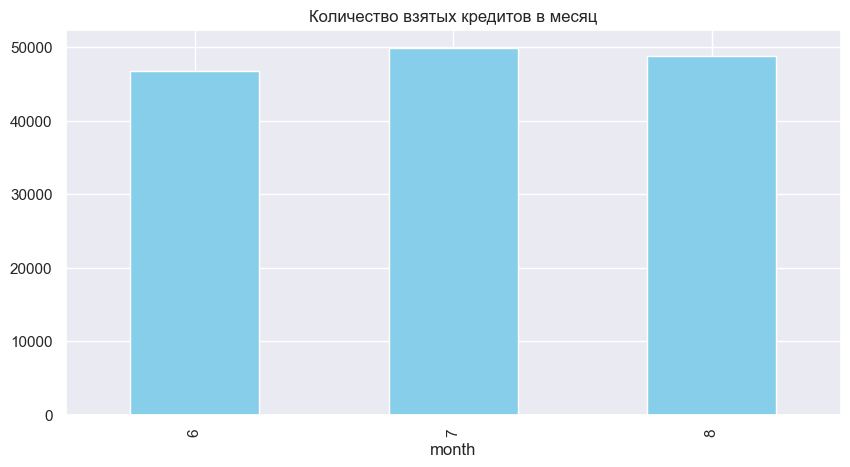

In [304]:
filtered_orders = orders[orders['overdue'] == 0]
orders['month'] = orders['created_at'].dt.month
count_debts = orders.groupby('month')['issued_sum'].count()
plt.figure(figsize=(10,5))
count_debts.plot(kind = 'bar', color = 'skyblue')
plt.title('Количество взятых кредитов в месяц')
plt.show()

Зависимости просрочек и месяца, когда был взят кредит нет.

### Итог:
* Процент просрочек = 25,2%
* Среднее количество дней задержки платежа по кредиту растет, к декабрю средняя задержка платежа достигает 50 дней
* Наибольшее количество задержанных платежей было в августе и сентябре
* Наибольшие платежи в сравнении с плановым вносили в июне
* В августе было наибольшее количество вовремя внесенных платежей по кредиту и стремительно падал с тех пор
* Динамика количества дней раннего внесения суммы задолжности положительная и в декабре достигает в среднем 10 дней
* Зависимости наличия задержек платежей от суммы или месяца взятия кредита нет